<a href="https://colab.research.google.com/github/tbt6776/safe-plannning/blob/main/tut2_optimization_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/sadraddini/pypolycontain.git

  Cloning https://github.com/sadraddini/pypolycontain.git to /tmp/pip-req-build-2dx002b0
  Running command git clone --filter=blob:none --quiet https://github.com/sadraddini/pypolycontain.git /tmp/pip-req-build-2dx002b0
  Resolved https://github.com/sadraddini/pypolycontain.git to commit a9aa1a6cff766c06fdb94aaca89a26471b7a9cb4
  Preparing metadata (setup.py) ... done
  Created wheel for pypolycontain: filename=pypolycontain-1.4-py3-none-any.whl size=27913 sha256=cf784fa0cdbe28cdc720a20a340e1d8e8c111036adf3af1331a1f4ad790a0f29
  Stored in directory: /tmp/pip-ephem-wheel-cache-72_o8r1h/wheels/35/f5/71/27eb24d2a4b3d9e653bfc1801694f70ba5d496d1765d107308
Successfully built pypolycontain


In [2]:
!pip install drake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 47.2 MB/s eta 0:00:00


In [3]:
# install dependencies
!pip install casadi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 12.8 MB/s eta 0:00:00


In [4]:
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

import pypolycontain as pp

from shapely.geometry import box, MultiPoint
from shapely.geometry import Polygon as Poly

/usr/local/lib/python3.12/dist-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/usr/local/lib/python3.12/dist-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/usr/local/lib/python3.12/dist-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/usr/local/lib/python3.12/dist-packages/pypolycontain/conversions.py:38: UserWarning: You don't have pydrake wit

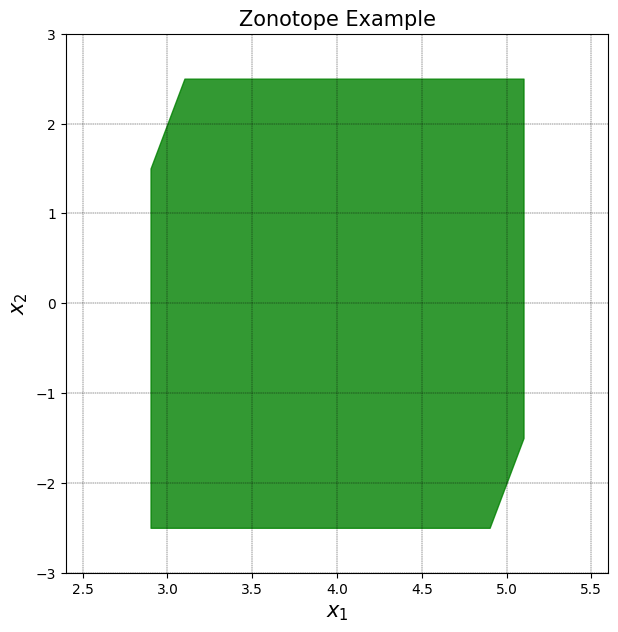

In [5]:
import matplotlib.pyplot as plt

# center of our zonotope
c = np.array([4, 0])
# generators of our zonotope, separated in x-row and y-row i.e. the first generator is (1,0)
g = np.array([[1, 0, 0.1], [0, 2, 0.5]])
# the center c is denoted by x in this library, don't get confused!
z = pp.zonotope(x=c, G=g)
z.color='green'

fig, ax = plt.subplots()
pp.visualize([z], title='Zonotope Example', fig=fig, ax=ax)       # pp.visualize() does all the hard work for us
fig.set_size_inches(7, 7)

# What if we have uncertainties such as initial positions? Feedback Motion Primitives!

In the previous setting, we have found an open loop trajectory for our robot. When applying this to a real robot it will most likely fail if we do not use a tracking controller to account for small deviations from the reference trajectory.

However, if we deviate from the reference trajectory, we are not ensured anymore that the robot will move on a collision-free trajectory. So in safety-critical applications, it is important to consider safety on different levels of the planning hierarchy (motion planning, control) in order to make our robots more robust.

In this section, we will look into Feedback motion primitives to ensure safety even if the reference trajectory cannot be tracked accurately.

In [6]:
import matplotlib.pyplot as plt

# Initial state of the robot
x0 = [0.5, 0.5, 0.]

# Goal state
xG = [3., 2., 0.]

# For collision checking we will overapproximate the robot with a circle of radius r
r = 0.15

N = 100
dt = 0.1

# Define obstacles in the environment (Each obstacle is defined by a list of its vertex positions)
obstacles = []
obstacles.append([[1., 0.5], [1.2, 0.8], [1.6, 0.3]])
obstacles.append([[0.6, 1.5], [0.4, 1.8], [1., 2.], [1., 1.6]])
obstacles.append([[1.4, 1.4], [2., 1.8], [2.3, 1.5], [1.9, 1.3]])
obstacles.append([[2.9, 1.3], [3.2, 1.7], [3.2, 0.9]])
obstacles.append([[2.5, 0.2], [2.2, 0.5], [2.4, 0.8], [2.8, 0.6]])
obstacles.append([[1.6, 2.5], [2., 2.9], [2.5, 2.4]])

patches = []
for obs in obstacles:
    p = Polygon(obs)
    patches.append(p)


from matplotlib.patches import Ellipse

# MVEE algorithm
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, np.linalg.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = np.linalg.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = np.linalg.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c

# initialize list of ellipsoids [(A_1, c_1), ...]
obstacle_ellipsoids = []

for obs in obstacles:
    A, c = mvee(np.array(obs))
    obstacle_ellipsoids.append((A, c))

ellipses = []
for (A, c) in obstacle_ellipsoids:
    # Eigendecomposition of A
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0])
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor([1, 0, 0])
    ellipses.append(ellipse)


# radius robot
r = 0.2

# init empty lists
enlarged_ellipses = []

# PUT YOUR CODE HERE
for (A, c) in obstacle_ellipsoids:
  Lambda, R = np.linalg.eig(A) # eigendecomposition of A => eigenvalue Lambda and eigenvector matrix R

  a = sqrt(1 / Lambda[0]) # radius of the obstacles
  b = sqrt(1 / Lambda[1])

  a_enlarged = a + r # ENLARGE THE RADIUS BY ADDING THE RADIUS OF THE ROBOT
  b_enlarged = b + r

  # A = R \Sigma R^T => A' = R \Sigma' R^T
  Lambda_enlarged = np.array([1/(a_enlarged ** 2), 1/(b_enlarged ** 2)])
  A_enlarged = R @ np.diag(Lambda_enlarged) @ R.T

  enlarged_ellipses.append((A_enlarged, c))


# generate plot objects
enlarged_ellipses_patches = []
for (A, c) in enlarged_ellipses:
  Lambda, R = np.linalg.eig(A)
  width = 2 * sqrt(1 / Lambda[0])
  height = 2 * sqrt(1 / Lambda[1])
  angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
  ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
  ellipse.set_edgecolor([0, 0, 1])
  enlarged_ellipses_patches.append(ellipse)



# velocity vectors in xy-plane
velocity_dirs = [[1., 0.], [1., 0.4], [0.4, -1.], [-1, 0.5], [-0.1, 1.], [1., 0.2]]

# velocity magnitudes
velocities = [0.1, 0.15, 0.1, 0.4, 0.3, 0.05]

# list of obstacles at each timestep
timed_obstacles = []
timed_obstacles.append(deepcopy(obstacles))

for k in range(1, N):
    # PUT YOUR CODE HERE
    # \Delta x = v_dir/|v_dir| velocity \Delta t
    # updating dynamic obstacle
    current_obs = []
    prev_obs_list = timed_obstacles[k-1]

    for j, obs in enumerate(prev_obs_list):
        dir_vec = np.array(velocity_dirs[j])
        dir_unit = dir_vec / np.linalg.norm(dir_vec)  # render np.array, and normalization

        Delta_x = dir_unit * velocities[j] * dt

        # shift each vertex
        new_obs = (np.array(obs) + Delta_x).tolist()
        current_obs.append(new_obs)

    timed_obstacles.append(current_obs)

timed_ellipses = []
# copying the elipsoid at t = 0
timed_ellipses.append(deepcopy(enlarged_ellipses))
# moving the center of elipsoid at t > 0
for k in range(1, N+1):
    ellipses_k = []
    for j, (A, c0) in enumerate(enlarged_ellipses):
        dir_vec = np.array(velocity_dirs[j])
        dir_unit = dir_vec / np.linalg.norm(dir_vec)
        step = dir_unit * velocities[j] * dt
        c_k = c0 + k * step
        ellipses_k.append((A, c_k))
    timed_ellipses.append(ellipses_k)




We first use our well-known dynamics model to be able to simulate our system.

In [7]:
def dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: derivative of the state vector
    """
    dx = np.array([- u[:, 0] * np.sin(x[:, 2]), u[:, 0] * np.cos(x[:, 2]), u[:, 1]]).T
    return dx


def discrete_dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: next state vector
    """
    dt = 0.1
    x_next = x + dt * dynamics(x, u)
    return x_next

Next, we will define our set of initial states as well as our input set. From this we will construct a **single** feedback motion primitive. Later, we will generalize these results to obtain multiple primitives that can be used for planning. In the following, define two zonotopes $X0$ and $U$ for the previously mentioned sets. The initial set is centered at the origin with orientation zero and has a total width of $0.1$ in each state direction. The input set is defined as $U = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, 0.5 \leq u_2 \leq 1\right\}$.

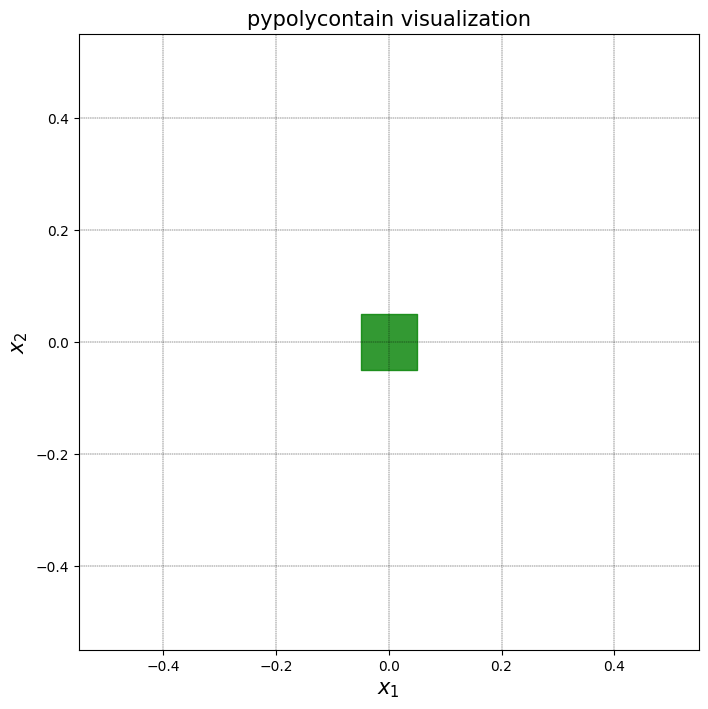

In [8]:
nx = 3
nu = 2

# X0
X0_c = np.array([0.0, 0.0, 0.0])
X0_G = np.diag([0.05, 0.05, 0.05])
X0 = pp.zonotope(x=X0_c, G=X0_G)

# U
U_c = np.array([(0.2 + 0.3)/2.0, (0.5 + 1.0)/2.0])
U_G = np.diag([(0.3 - 0.2)/2.0, (1.0 - 0.5)/2.0])
U = pp.zonotope(x=U_c, G=U_G)

# visualize initial set
fig, ax = plt.subplots()
pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :])], ax=ax, fig=fig)

Next, we would like to be able to sample trajectories from our system given the initial states and the input sets. For that purpose, we need a function that allows us to sample a point from a zonotope.

In [9]:
def sample_zonotope(zt):
  """
  Input: pp zonotope
  Output: uniformly sampled point inside zonotope
  """
  c = zt.x
  G = zt.G
  num_sample = G.shape[1]

  x_random = np.random.uniform(-1.0, 1.0, size = num_sample) # generates ramdom sample
  x_sample = c + G @ x_random
  return x_sample

We will now sample a bunch of initial states and input trajectories of length $N_s = 20$ to fit a linear model to the multi-step solution of our dynamical system. Fill the matrices!

In [10]:
# number of timesteps for feedback motion primitive
N_s = 20

# sampled trajectories
n_samples = 10000

state_traces = np.zeros((n_samples, nx, N_s))
input_traces = np.zeros((n_samples, nu, N_s - 1))

#PUT YOUR CODE HERE

for i in range(n_samples):
  # sampling initial state from X0
  x = sample_zonotope(X0) # 3 dimensions(x, y, angle)
  # print(len(x))
  state_traces[i, :, 0] = x
  # print(state_traces)

  # update the states
  for k in range(N_s - 1):
    u = sample_zonotope(U)       # two dimensions(u1, u2)
    # print(len(u))
    input_traces[i, :, k] = u # k-th timesteps
    # print(input_traces)

    # adjusting the dimension
    x_next = discrete_dynamics(x.reshape(1, -1), u.reshape(1, -1))
    x = x_next.flatten()

    state_traces[i, :, k+1] = x # k+1-th timestep

Next, we're gonna fit a linear model for the transition from initial state $x_0$ to the state after $x_{T}$ after $N_s=20$ timesteps. Note, that this is not a linear model relating the state at the next time step to the current one, but predicting the state after $T$ timesteps, i.e.

$$
\mathbf{x}_{t+N_s} = \mathbf{A} \mathbf{x}_t + \mathbf{B} \begin{bmatrix}
\mathbf{u}_t\\
\mathbf{u}_{t+1}\\
\vdots\\
\mathbf{u}_{t+N_s - 1}
\end{bmatrix} + \mathbf{c}
$$

where $\mathbf{A} \in \mathbb{R}^{n_x \times n_x}, \mathbf{B} \in \mathbb{R}^{n_x \times (N_s-1) n_u}$ and $\mathbf{c}\in \mathbb{R}^{n_x}$. To find this model, we will make use of the LinearRegression function in `sklearn`. Since this is mainly annoying formatting, the function is provided in the following. To ensure that we are not overfitting to the data, we seperate the input and outputs into a training and test set. At the end, an approximate linearization error is calculated based on the error on a test set.

In [11]:
from sklearn.linear_model import LinearRegression

# Seperate data into training and test set: 2/3 training 1/3 test
ind = int(np.floor((2/3) * n_samples))

# training set
initial_states_train = state_traces[:ind, :, 0]
inputs_train = np.moveaxis(input_traces[:ind, :, :], 1, -1).reshape((ind, -1))
training_input = np.concatenate((initial_states_train, inputs_train), axis=1)
training_output = state_traces[:ind, :, -1]
model = LinearRegression().fit(training_input, training_output)

# obtain model
A = model.coef_[:, :nx]
B = model.coef_[:, nx:]
c = model.intercept_


# test set
initial_states_test = state_traces[ind:, :, 0]
inputs_test = np.moveaxis(input_traces[ind:, :, :], 1, -1).reshape((n_samples - ind, -1))
test_input = np.concatenate((initial_states_test, inputs_test), axis=1)
test_output = state_traces[ind:, :, -1]

# Error on training set
prediction = model.predict(training_input)
err_training = abs(prediction - training_output)
max_error_training = np.max(err_training, axis=0)
print("Max error on training data: " + str(max_error_training))

# Error on test set
prediction = model.predict(test_input)
err_test = abs(prediction - test_output)
max_error_test = np.max(err_test, axis=0)
print("Max error on test data: " + str(max_error_test))

# overapproximate linearization error
linearization_error = max_error_test * 1.5



Max error on training data: [5.75848328e-03 7.71945440e-03 3.10862447e-15]
Max error on test data: [6.64628891e-03 4.73060076e-03 3.10862447e-15]


Now, we've fitted a linear model to the transition which allows us to calculate reachable sets! Overall, the reachable set of our system after $T$ steps can be obtained as

$$
\begin{align}
\mathcal{R}_T &= \left\{\mathbf{A} \mathbf{x}_0 + \mathbf{B} \mathbf{u}_{0:(N_s-1)} + c \mid \mathbf{x}_0 \in X0, \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&= \left\{\mathbf{A} \mathbf{x}_0 + c \mid \mathbf{x}_0 \in X0\right\} \bigoplus \left\{\mathbf{B} \mathbf{u}_{0:(N_s-1)}\mid \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&:= \mathcal{R}_x \bigoplus \mathcal{R}_u
\end{align}
$$

Calculate these zonotopes!

In [12]:
print(U.x)
print(U.G)

[0.25 0.75]
[[0.05 0.  ]
 [0.   0.25]]


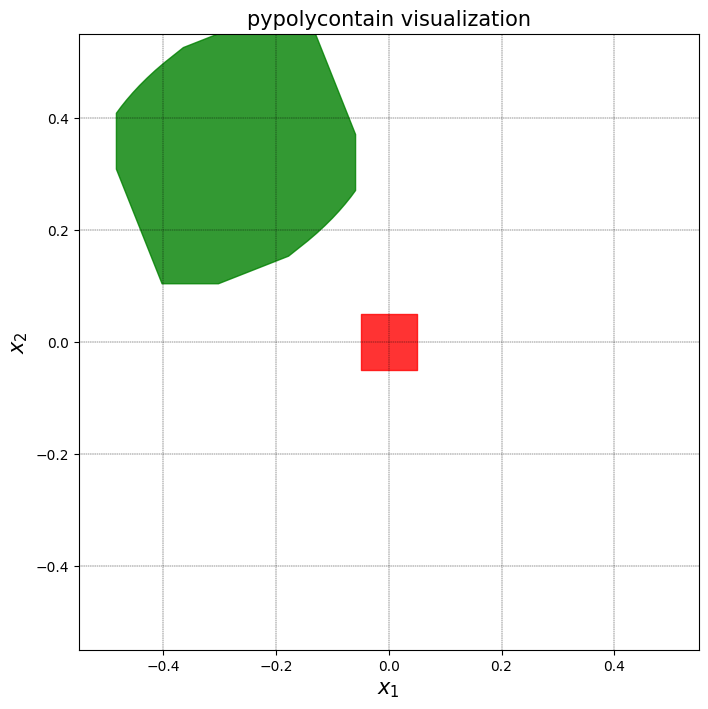

In [13]:
# zonotopes of R_x
Rx_center = A @ X0.x + c              # center
Rx_G = A @ X0.G                       # generator
Rx = pp.zonotope(x=Rx_center, G=Rx_G)

# zonotopes of R_u
# pile input u from 0 to N_s - 1
# center
stack_list_x = []
for _ in range(N_s - 1):
    stack_list_x.append(U.x)
U_center_stack = np.vstack(stack_list_x).reshape(-1)
# print(U_center_stack)

# generator => place U.G on the diagonal blocks of the block martix
U_G_stack = np.kron(np.eye(N_s - 1), U.G) #  introducing kronecker
# print(U_G_stack)

U_traj = pp.zonotope(x=U_center_stack, G=U_G_stack)

# mulpiply by B
Ru_center = B @ U_traj.x
Ru_G = B @ U_traj.G
Ru = pp.zonotope(x=Ru_center, G=Ru_G)

# Minkowski sum
R_center = Rx.x + Ru.x
R_G = np.concatenate((Rx.G, Ru.G), axis=1)
R = pp.zonotope(x=R_center, G=R_G)

# visualization of Reachable set (projected to xy-plane)
fig, ax = plt.subplots()
# 2D zonotope
R2d = pp.zonotope(x=R.x[0:2],G=R.G[0:2,:])
pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)
pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :], color='red')], fig=fig, ax=ax)
plt.show()

In [14]:
# Linearization Error bounds as zonotope
Rw = pp.zonotope(x=np.zeros(3), G=np.diag(linearization_error))

Here, we will also visualize some of the sampled trajectories. Why is the reachable set much larger than the actual sampled final states? In case you want to find out, sample some trajectories where you just take the extreme values of $\mathbf{u}$ over the entire trajectory and visualize them!

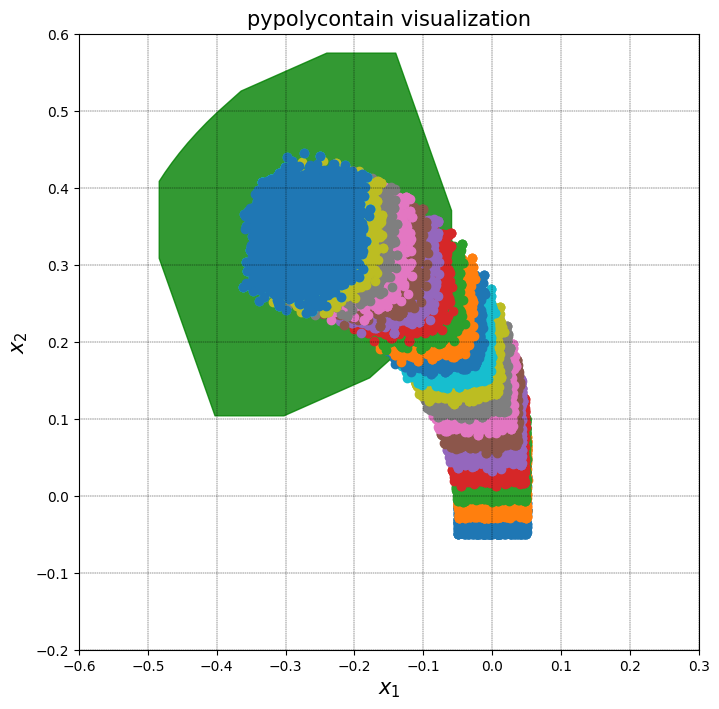

In [15]:
fig, ax = plt.subplots()
pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)

idx = np.random.randint(n_samples, size=10000)

# Optional: sample corner case scenarios and visualize them

for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax.set_xlim([-0.6, 0.3])
ax.set_ylim([-0.2, 0.6])
plt.show()

Now, the goal is to find a control policy $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0$ s.t. the reachable set is shrunk to the linearization error meaning that $\mathcal{R}_u$ cancels out $\mathcal{R}_x$, i.e. $\mathbf{A} - \mathbf{BK} = \mathbf{0}$. Note, that this is a mapping from the initial state to a sequence of control inputs, thus $\mathbf{K} \in \mathbb{R}^{n_x \times n_u (N_s - 1)}$. However, this problem cannot be uniquely solved since the $\mathbf{B}$ matrix is not invertible. One approach to solve for a feedback matrix is to use the pseudoinverse $\mathbf{K} = \mathbf{B}^\dagger \mathbf{A}$ which, however, does not ensure that our inputs $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0 \in U$ are inside the feasible control set. An alternative is to formulate this as an optimization problem in which we would like to minimize the control effort (magnitude of $\mathbf{K}$) subject to reachable set cancellation and input constraints:

$$
\begin{aligned}
	\min_{K = [K_{ij}]} \quad &[K_{11}, K_{12}, \dots, K_{nm}]^T Q [K_{11}, K_{12}, \dots, K_{nm}]\\
	\textrm{s.t.  } \quad  &A - BK= 0\\
  \quad &-Kv \in U, \forall v \in \mathrm{vertices}(X0)
    \end{aligned}.
$$
Due to linearity, it is sufficient to enforce input constraints at the vertices of the initial state set!

In the last tutorial, we have used pythons `CVXOPT` library to efficiently solve a quadratic program for control synthesis. Since the optimization problem is also a QP, we can make use of the same library. Have a look at $\href{https://cvxopt.org/examples/tutorial/qp.html}{this} $ example on formulating a QP in cvxopt.

In [16]:
from cvxopt import matrix, solvers
from itertools import product
import numpy as np

# solve with np type

# dimensions
Kx = nx                        # state dimension
Ky = nu * (N_s - 1)            # stacked inputs
dim_all = Kx * Ky         # sum of dimension

# equality condition
# A - BK = 0 => A_eq x = b_eq
# I \kron B vec(K) = vec(A)
Q = matrix(np.eye(dim_all))
p = matrix(np.zeros(dim_all))
Aeq_np = np.kron(np.eye(Kx), B)
beq_np = A.reshape(-1, order='F') # [[1,2],[3,4]] => [1,3,2,4]
A_eq = matrix(Aeq_np)
b_eq = matrix(beq_np)


# Inequality condition
# u_ff - Kv \in U for all v \in vertices(X_0)
# u_min < u_ff - Kv < u_max
# u_ff - u_max < Kv < u_ff - u_min

u_min_step = np.array([0.2, 0.5])
u_max_step = np.array([0.3, 1.0])
u_ff = (u_min_step + u_max_step) / 2.0       # u_ff： center of the input set U

delta_min = u_ff - u_max_step                # two dimension
delta_max = u_ff - u_min_step

# pile them for Kv
u_delta_min = np.tile(delta_min, N_s - 1)
u_delta_max = np.tile(delta_max, N_s - 1)

# the rest task is to make Kv, but we just consider the vertices of X_0


# vertices of X0
# print(X0.G)
# print(X0.G.shape[1])
mX = X0.G.shape[1] # shape[0] is the number of states, shape[1] is the number of generators
vertices = []
# we need to get vertices of X0 zonotope
# => product: one signs is one combination of ±1 for the mX-dimensional generator vector
# ex) (-1, -1, -1), (-1, -1, +1), ..., (+1, +1, +1)
for signs in product([-1.0, 1.0], repeat=mX):
    s = np.array(signs)
    v = X0.x + X0.G @ s # we get one vertex
    vertices.append(v)
vertices = np.array(vertices)

print(vertices)

# change the matrix K into a vector type
# Kv = v_1 K[1st column] + v_2 K[2nd column] + ... + v_n K[nth column]
# we have to set the vec(K) according to the equality condition

G_list, h_list = [], []
I_ineq = np.eye(Ky)

for v in vertices:
  print(v)
  v = v.reshape(-1, 1)
  print(v)
  M_v = np.kron(v.T, I_ineq) # use kronecker for v

  # delta_min <= K v <= delta_max

  # K v <= delta_max
  G_list.append(M_v)
  h_list.append(u_delta_max)

  # K v >= delta_min
  # -K v <= -delta_min
  G_list.append(-M_v)
  h_list.append(-u_delta_min)

G_ineq_np = np.vstack(G_list)
h_ineq_np = np.hstack(h_list)

G_ineq = matrix(G_ineq_np)
h_ineq = matrix(h_ineq_np)

# solve QP!!

solvers.options['show_progress'] = True
sol = solvers.qp(Q, p, G_ineq, h_ineq, A_eq, b_eq)
K = np.array(sol['x']).reshape(Ky, Kx, order="F")

# sol = solvers.qp(Q, p, None, None, A_eq, b_eq)
# sol = solvers.qp(Q, p, G_ineq, h_ineq)
# print(sol['status'])
# K_vec = np.array(sol['x']).flatten()
# K = K_vec.reshape((Ky, Kx), order='F')
# print(A - B @ K)


[[-0.05 -0.05 -0.05]
 [-0.05 -0.05  0.05]
 [-0.05  0.05 -0.05]
 [-0.05  0.05  0.05]
 [ 0.05 -0.05 -0.05]
 [ 0.05 -0.05  0.05]
 [ 0.05  0.05 -0.05]
 [ 0.05  0.05  0.05]]
[-0.05 -0.05 -0.05]
[[-0.05]
 [-0.05]
 [-0.05]]
[-0.05 -0.05  0.05]
[[-0.05]
 [-0.05]
 [ 0.05]]
[-0.05  0.05 -0.05]
[[-0.05]
 [ 0.05]
 [-0.05]]
[-0.05  0.05  0.05]
[[-0.05]
 [ 0.05]
 [ 0.05]]
[ 0.05 -0.05 -0.05]
[[ 0.05]
 [-0.05]
 [-0.05]]
[ 0.05 -0.05  0.05]
[[ 0.05]
 [-0.05]
 [ 0.05]]
[ 0.05  0.05 -0.05]
[[ 0.05]
 [ 0.05]
 [-0.05]]
[0.05 0.05 0.05]
[[0.05]
 [0.05]
 [0.05]]
     pcost       dcost       gap    pres   dres
 0:  2.2102e+01 -7.7629e+01  9e+02  6e+00  2e-15
 1:  2.2105e+01 -4.9908e+01  1e+02  7e-01  1e-15
 2:  2.3867e+01 -3.2190e+01  1e+02  5e-01  3e-15
 3:  3.1442e+01 -2.0512e+00  9e+01  3e-01  1e-14
 4:  4.6253e+01  2.7423e+01  6e+01  1e-01  2e-14
 5:  5.4978e+01  3.9302e+01  4e+01  7e-02  1e-14
 6:  6.1292e+01  5.1971e+01  2e+01  3e-02  1e-14
 7:  6.5139e+01  5.9548e+01  1e+01  1e-02  2e-14
 8:  6.7198e+

Let's see if it worked! Use the initial state set X0 and forward propagate the closed loop dynamics!

(-0.1, 1.0)

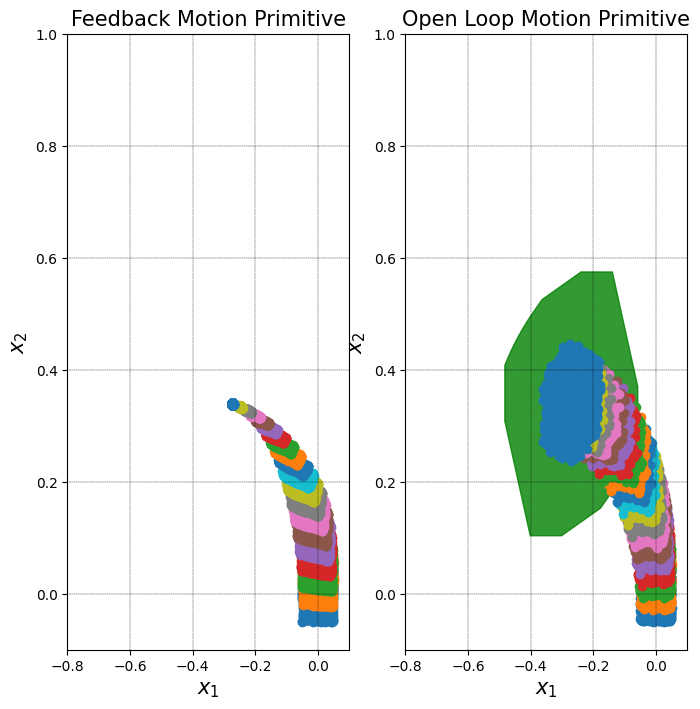

In [17]:
# state trajectories for controlled system
feedback_state_traces = np.zeros((n_samples, nx, N_s))

# PUT YOUR CODE HERE
u_ff_stack = np.tile(U.x, N_s - 1)

# なぜ初期状態x0だけから決めている？
for i in range(n_samples):
    x = sample_zonotope(X0) # x at the time of time 0 => updating for k in range(N_s - 1)
    feedback_state_traces[i, :, 0] = x

    u_stack = u_ff_stack - K @ x # we can determine feedback input u using inital state x0

    for k in range(N_s - 1):
        u_k = u_stack[nu * k : nu * (k + 1)]  # input at the time of k
        x_next = discrete_dynamics(x.reshape(1, -1), u_k.reshape(1, -1))
        x = x_next.flatten()
        feedback_state_traces[i, :, k + 1] = x

# visualizations
fig = plt.figure()
ax = fig.add_subplot(121)

# Visualize feedback samples
idx = np.random.randint(n_samples, size=1000)
pp.visualize([pp.zonotope(x=Rw.x[0:2] + R.x[0:2], G=Rw.G[0:2, :])], fig=fig, ax=ax, title="Feedback Motion Primitive")
for i in range(0, N_s):
    plt.scatter(feedback_state_traces[idx, 0, i], feedback_state_traces[idx, 1, i])
plt.scatter(feedback_state_traces[:, 0, -1], feedback_state_traces[:, 1, -1])
ax.set_xlim([-0.8, 0.1])
ax.set_ylim([-0.1, 1.])

ax1 = fig.add_subplot(122)

# visualize open loop samples
idx = np.random.randint(n_samples, size=1000)
pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax1, title="Open Loop Motion Primitive")
for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax1.set_xlim([-0.8, 0.1])
ax1.set_ylim([-0.1, 1.])

**We are almost there!** We now have a single feedback motion primitive and we have canceled out the two reachable sets $\mathcal{R}_x$ and $\mathcal{R}_u$ and are only left with the linearization error. For our future analysis we are not only interested in where the robot will end up but also in all possible positions that the robot might reach when using the obtained controller. Thus, we are interested in the reachable tube of the feedback motion primitive! Since we've done a discrete analysis, we have to be careful as we are not entirely sure what happens in between discrete time steps... Next, use the samples from the closed loop system to obtain polygons that contain all the samples at each discrete time step $t_i$. Then, use some method to account for the continuous-time evolution in between time steps.

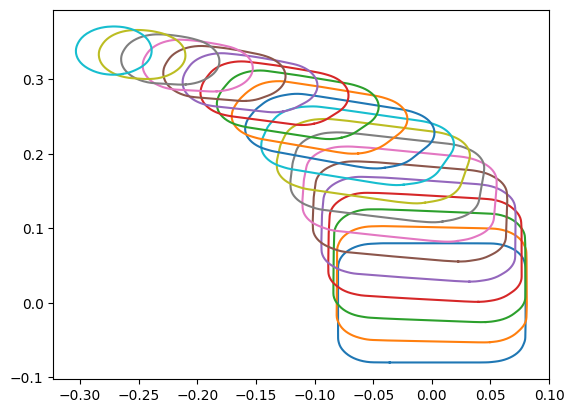

In [28]:
# reachable tube (list of polygons, I use shapely polygons since we will use
# these polygons for collision checking but feel free to use another representation)
reachable_tube = []

# PUT YOUR CODE HERE
# vmax
v_max = 0.3     # [m/s]
dt = 0.1
r_buffer = v_max * dt # discrete time set => continuous time set by using possible maximum motion
# it is also effective to multiply 1.1 or smth if the sample is large enough

for k in range(N_s):
    pts = [(feedback_state_traces[i, 0, k], feedback_state_traces[i, 1, k]) for i in range(n_samples)] # 10000 sample states at the time of k

    mp = MultiPoint(pts) # set of mulit points in shapely
    # print(mp)
    hull = mp.convex_hull # make convex hull including the set of multi points
    # print(hull)

    tube_piece = hull.buffer(r_buffer)
    # tube_piece = hull
    reachable_tube.append(tube_piece)

# Visualization (If you don't use shapely polygons you might change the plotting command)
fig = plt.figure()
ax = fig.add_subplot(111)
for p in reachable_tube:
  x, y = p.exterior.coords.xy
  plt.plot(x, y)

# the dynamical path in continous time must be included in this area

Amazing! Recap what we've just obtained: We have

1.   a contracting motion primitive (Final set is smaller than initial set)
2.   a controller $\mathbf{u}_{0:(N_s - 1)} = - \mathbf{K} \mathbf{x}_0$ that maps the initial state to a sequence of control inputs
3. a reachable tube that can be used for collision checking



# Long horizon planning using Feedback Motion Primitives!

Now you know how to generate a single feedback motion primitive given an initial state set $X0$ as well as an input set $U$. The cool thing about feedback motion primitives is that they are a contraction on the state set meaning that they always "shrink" the initial state set. Thus, if we have multiple feedback motion primitives, we can concatenate them since the initial set of a motion primitive is always larger than the end of a motion. This concept is illustrated in the following figure.

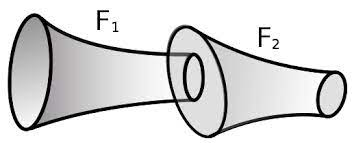

The goal of this section is to come up with an algorithm that connects multiple feedback motion primitives such that we can reach a goal while avoiding collisions with obstacles. We will consider the same static environment as in the first section.

Implement a function that returns N feedback motion primitives starting at the initial set $X0$ with different input sets $U_1, \dots, U_N$ where each input set is defined as $U_i = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, u_{i, min} \leq u_2 \leq u_{i, max}\right\}$. The input sets should be distributed equidistantly, e.g. $u_{1, min} = u_{min}, u_{N, max} = u_{max}$ and $u_{i, max} = u_{i+1, min}$. Also, represent each feedback motion primitive as a class object of type FBMotion. We later want to use these primitives for collision checking, so it will be useful to also include attributes such as reachable_tube.

In [19]:
from shapely.geometry import MultiPoint

class FBMotion:
    def __init__(self, X0_set, U_set):
        self.X0 = X0_set
        self.U  = U_set
        self.K  = None
        self.reachable_tube = []
        self.feedback_state_traces = None

        # 1) この U に対して K を計算
        self._compute_feedback_gain()

        # 2) K を使って閉ループサンプルを流し、reachable tube を作る
        self._build_reachable_tube()

    def _compute_feedback_gain(self):
        """さっきやった QP（A - BK = 0 と入力制約）で K を求める"""

        Kx = nx
        Ky = nu * (N_s - 1)
        n_var = Kx * Ky

        # ===== コスト: ||K||_F^2 =====
        Q = matrix(2.0 * np.eye(n_var))
        p = matrix(np.zeros(n_var))

        # ===== 等式制約: A - B K = 0 =====
        Aeq_np = np.kron(np.eye(Kx), B)          # (nx*Kx, n_var)
        beq_np = A.reshape(-1, order='F')        # vec(A)

        A_eq = matrix(Aeq_np)
        b_eq = matrix(beq_np)

        # ===== 不等式: u_min <= u_ff - K v <= u_max =====
        # U_set はゾノトープなので、そこから min/max を計算
        #   中心 U.x, ジェネレータ U.G (対角) を使って
        G_abs = np.abs(self.U.G)
        u_min_step = self.U.x - np.sum(G_abs, axis=1)   # [u1_min, u2_min]
        u_max_step = self.U.x + np.sum(G_abs, axis=1)   # [u1_max, u2_max]

        u_ff = self.U.x                   # feedforward (U の中心)
        delta_min = u_ff - u_max_step     # 各成分の下側バッファ
        delta_max = u_ff - u_min_step     # 各成分の上側バッファ

        u_delta_min = np.tile(delta_min, N_s - 1)   # (Ky,)
        u_delta_max = np.tile(delta_max, N_s - 1)   # (Ky,)

        # X0 の頂点を列挙
        mX = self.X0.G.shape[1]
        vertices = []
        for signs in product([-1.0, 1.0], repeat=mX):
            s = np.array(signs)
            v = self.X0.x + self.X0.G @ s
            vertices.append(v)
        vertices = np.array(vertices)

        G_list = []
        h_list = []

        I_Ky = np.eye(Ky)

        for v in vertices:
            v = v.reshape(-1, 1)                 # (nx,1)
            M_v = np.kron(v.T, I_Ky)            # K v = M_v vec(K)

            # delta_min <= K v <= delta_max
            # 1) K v <= delta_max
            G_list.append(M_v)
            h_list.append(u_delta_max)

            # 2) K v >= delta_min  ->  -K v <= -delta_min
            G_list.append(-M_v)
            h_list.append(-u_delta_min)

        G_ineq_np = np.vstack(G_list)
        h_ineq_np = np.hstack(h_list)

        G_ineq = matrix(G_ineq_np)
        h_ineq = matrix(h_ineq_np)

        # ===== QP を解く =====
        solvers.options['show_progress'] = False
        sol = solvers.qp(Q, p, G_ineq, h_ineq, A_eq, b_eq)

        K_vec = np.array(sol['x']).flatten()
        Ky = nu * (N_s - 1)
        self.K = K_vec.reshape((Ky, nx), order='F')

    def _build_reachable_tube(self):
        """K を使って閉ループサンプルを流し、reachable tube（多角形のリスト）を作る"""

        feedback_state_traces = np.zeros((n_samples, nx, N_s))

        # feedforward 入力系列（各ステップ同じ U の中心）
        u_ff_step = self.U.x              # shape (2,)
        u_ff_stack = np.tile(u_ff_step, N_s - 1)  # shape (Ky,)

        for i in range(n_samples):
            x = sample_zonotope(self.X0)
            feedback_state_traces[i, :, 0] = x

            u_stack = u_ff_stack - self.K @ x     # (Ky,)

            for k in range(N_s - 1):
                u_k = u_stack[nu * k : nu * (k + 1)]
                x_next = discrete_dynamics(x.reshape(1, -1),
                                           u_k.reshape(1, -1))
                x = x_next.flatten()
                feedback_state_traces[i, :, k + 1] = x

        self.feedback_state_traces = feedback_state_traces

        # ---- 各ステップごとに convex hull → バッファ ----
        v_max = 0.3
        dt = 0.1
        r_buffer = 1.2 * v_max * dt

        self.reachable_tube = []
        for k in range(N_s):
            pts = [(feedback_state_traces[i, 0, k],
                    feedback_state_traces[i, 1, k])
                   for i in range(n_samples)]

            mp = MultiPoint(pts)
            hull = mp.convex_hull

            if hull.geom_type != "Polygon":
                hull = hull.buffer(1e-4)

            tube_piece = hull.buffer(r_buffer)
            self.reachable_tube.append(tube_piece)

    def plot(self, ax):
        """reachable tube をプロット"""
        for p in self.reachable_tube:
            x, y = p.exterior.coords.xy
            ax.plot(x, y)


In [20]:
def generate_feedback_motion_primitives(X, u_min, u_max, N):
    """
    X      : 初期状態集合 X0 (zonotope)
    u_min  : u2 の最小値
    u_max  : u2 の最大値
    N      : Motion Primitive の本数
    """
    motion_primitives = []

    # u2 を N 区間に等分
    edges = np.linspace(u_min, u_max, N + 1)

    u1_min = 0.2
    u1_max = 0.3

    for i in range(N):
      u2_min = edges[i]
      u2_max = edges[i + 1]

      # U_i を zonotope として定義
      u_center = np.array([(u1_min + u1_max)/2, (u2_min + u2_max)/2])
      print(u_center)
      u_delta_range = np.array([(u1_max - u1_min)/2, (u2_max - u2_min)/2])
      print(u_delta_range)
      U_G = np.diag(u_delta_range)
      U_i = pp.zonotope(x=u_center, G=U_G)

      # この U_i から FBMotion を作る
      mp = FBMotion(X, U_i)
      motion_primitives.append(mp)

    return motion_primitives

# 例: u2 ∈ [-1, 1] を 11 本に分割
u_min = -1.0
u_max =  1.0
primitives = generate_feedback_motion_primitives(X0, u_min, u_max, 11)


[ 0.25       -0.90909091]
[0.05       0.09090909]
[ 0.25       -0.72727273]
[0.05       0.09090909]
[ 0.25       -0.54545455]
[0.05       0.09090909]
[ 0.25       -0.36363636]
[0.05       0.09090909]
[ 0.25       -0.18181818]
[0.05       0.09090909]
[0.25 0.  ]
[0.05       0.09090909]
[0.25       0.18181818]
[0.05       0.09090909]
[0.25       0.36363636]
[0.05       0.09090909]
[0.25       0.54545455]
[0.05       0.09090909]
[0.25       0.72727273]
[0.05       0.09090909]
[0.25       0.90909091]
[0.05       0.09090909]


Let's have a look at our motion primitives!

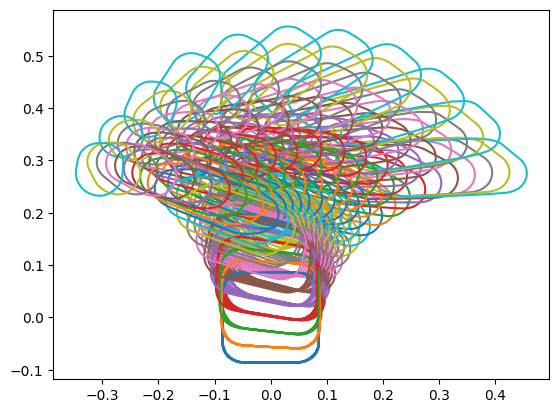

In [21]:
fig, ax = plt.subplots()
for p in primitives:
  p.plot(ax)

## A* path planning algorithm using motion primitives
In this last step, we will use the obtained N feedback motion primitives for a dynamically feasible A* search. In this section you are free in the way you implement the algorithm, e.g. how to choose costs and heuristics. The goal is to find a sequence of feedback motion primitives that bring the robot from its initial state $x_0$ to the goal state $x_G$ while always staying in the free space $\mathcal{X}\setminus \mathcal{X}_{obs}$.

Here are a couple of hints:


1.   Feedback motion primitives can be shifted and rotated in the configuration space. The final polygon of a motion primitive should always be entirely contained in the first polygon of the next motion primitive when concatenating them.
2.   It is fine if you find a solution that is "close" to the goal state. A solution is accepted if the center of the final polygon $c$ satisfies $\lVert \mathbf{c}_N - \mathbf{x}_G\rVert_2 \leq 0.2$.
3. You can use `shapely.affinity` for transformations and rotations of shapely polygons.
4. Optimality of the solution is not required.
5. The complexity of collision checking can be reduced by first using an overapproximation of the reachable tube. If that over approximation is collision free, you don't need to do complex collision checking.
6. A lot of implementations of the standart A* algorithm in python can be found online ;)
7. A feasible solution could look something like this:

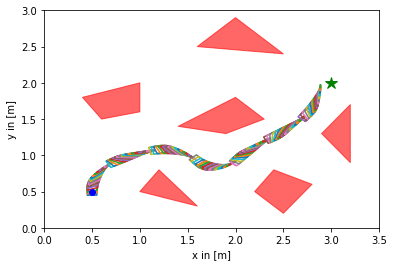



In [22]:
import heapq

class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position

    def __lt__(self, other):
        return self.f < other.f

def heuristic(node1, node2):
    return abs(node1.position[0] - node2.position[0]) + abs(node1.position[1] - node2.position[1])

def calculate_f(node):
    node.f = node.g + node.h

def reconstruct_path(current_node):
    path = []
    while current_node is not None:
        path.append(current_node.position)
        current_node = current_node.parent
    return path[::-1]

def add_to_open(open_list, neighbor_node):
    for node in open_list:
        if neighbor_node == node and neighbor_node.g >= node.g:
            return False
    return True

def a_star(start, goal, grid):
    start_node = Node(start)
    goal_node = Node(goal)

    open_list = []
    closed_list = []
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)

        if current_node == goal_node:
            return reconstruct_path(current_node)

        closed_list.append(current_node)

        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            if node_position not in grid:
                continue

            neighbor_node = Node(node_position, current_node)

            if neighbor_node in closed_list:
                continue

            neighbor_node.g = current_node.g + 1
            neighbor_node.h = heuristic(neighbor_node, goal_node)
            calculate_f(neighbor_node)

            if add_to_open(open_list, neighbor_node):
                heapq.heappush(open_list, neighbor_node)

    return None


n_grid = 5 # grid number?

grid = [(x, y) for x in range(n_grid) for y in range(n_grid)]
start = (0.5, 0.5)  # start
goal = (3., 2.)  # goal

# A*
path = a_star(start, goal, grid)

In [23]:
from shapely import affinity

# feel free to use any other polygon representation
obstacles_shapely = [Polygon(o) for o in obstacles]

# robots initial state
x0 = np.array([0.5,0.5,0])
# goal state
xG = np.array([3., 2, 0])
# collision radius of robot
r = 0.2

# PUT YOUR CODE HERE AND VISUALIZE YOUR RESULTS

## Optional: Test your results and compare

In case you are interested in how the robustness increases using feedback motion primitives, run two simulations of the drone operating in the environment. In this simulation, pick a random initial state from $X0$ and simulate the system with the inputs obtained in the E-level problem as well as the feedback motion primitives. Which one is more robust?